# **Modelling 1 : XGBoost and Adaboost**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
! pip install missingno
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import auc, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, average_precision_score, recall_score, f1_score, precision_recall_curve, cohen_kappa_score, confusion_matrix,  classification_report
! pip install yellowbrick 
from yellowbrick.classifier import ConfusionMatrix, ROCAUC


#### Train

In [131]:
X_train = pd.DataFrame(fraud_prepared, columns = num_attribs+ cat_attribs)
y_train = fraud_labels

#### Validation

In [132]:
fraud = fraud_val.copy()
#Used two separate pipelines as the input data structure for both are different
fraud_prepared = common_pipeline.fit_transform(fraud)
fraud_prepared = pd.DataFrame(fraud_prepared, columns = fraud.columns)
fraud_labels = fraud_prepared["FraudFound_P"].copy()
fraud_prepared = fraud_prepared.drop("FraudFound_P", axis=1)
fraud_prepared = full_pipeline.fit_transform(fraud_prepared)

X_val = pd.DataFrame(fraud_prepared, columns = num_attribs+ cat_attribs)
y_val = fraud_labels

#### Test

In [133]:
fraud = fraud_test.copy()
#Used two separate pipelines as the input data structure for both are different
fraud_prepared = common_pipeline.fit_transform(fraud)
fraud_prepared = pd.DataFrame(fraud_prepared, columns = fraud.columns)
fraud_labels = fraud_prepared["FraudFound_P"].copy()
fraud_prepared = fraud_prepared.drop("FraudFound_P", axis=1)
fraud_prepared = full_pipeline.fit_transform(fraud_prepared)

X_test = pd.DataFrame(fraud_prepared, columns = num_attribs+ cat_attribs)
y_test = fraud_labels

## **Data acquisition**

In [285]:
train = pd.read_csv("Fraud_sampledtrain.csv")

train.drop("Unnamed: 0", inplace= True, axis=1)
y_train= train["FraudFound_P"]
X_train = train.drop("FraudFound_P", axis=1)


val = pd.read_csv("Fraud_val.csv")
val.drop("Unnamed: 0", inplace= True, axis=1)
y_val= val["FraudFound_P"]
X_val = val.drop("FraudFound_P", axis=1)


test = pd.read_csv("Fraud_test.csv")
test.drop("Unnamed: 0", inplace= True, axis=1)
y_test= test["FraudFound_P"]
X_test = test.drop("FraudFound_P", axis=1)

#fraud_labels = fraud["FraudFound_P"].copy()
#fraud = fraud.drop("FraudFound_P", axis=1)

val.columns

Index(['MonthOfAccident', 'WeekOfMonthOfAccident', 'MonthClaimed',
       'WeekOfMonthClaimed', 'AgeOfPolicyHolder', 'RepNumber', 'Deductible',
       'DriverRating', 'PoliceReportFiled', 'WitnessPresent', 'Year',
       'DayOfWeekOfAccident', 'Make', 'AccidentArea', 'DayOfWeekClaimed',
       'Sex', 'MaritalStatus', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePriceRange', 'Days_Policy_Accident', 'Days_Policy_Claim',
       'PastNumberOfClaims', 'AgeOfVehicle', 'AgeRangeOfPolicyHolder',
       'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim',
       'NumberOfCars', 'BasePolicy', 'FraudFound_P'],
      dtype='object')

In [286]:
# !pip install xgboost 
import xgboost as xgb

In [287]:
# Plot precision recall curve

def plot_pr_curve(precision, recall, average_precision, clf):
    viz = PrecisionRecallCurve(clf, is_fitted=True)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()
    # plt.step(recall, precision, color='b', alpha=0.2, where='post')
    # plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    # plt.xlabel('Recall')
    # plt.ylabel('Precision')
    # plt.ylim([0.0, 1.05])
    # plt.xlim([0.0, 1.0])
    # plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    # plt.show()

In [288]:
# Plot ROC curve

def plot_roc_curve(fpr, tpr, roc_auc, clf):
  classes = ["0", "1"]

  visualizer = ROCAUC(
      clf, classes=classes, is_fitted=True
  )

  visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
  visualizer.score(X_test, y_test)        # Evaluate the model on the test data
  visualizer.show()  
    # plt.title('Receiver Operating Characteristic')
  # plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    # plt.legend(loc = 'lower right')
    # plt.plot([0, 1], [0, 1],'r--')
    # plt.xlim([0, 1])
    # plt.ylim([0, 1])
    # plt.ylabel('True Positive Rate')
    # plt.xlabel('False Positive Rate')
    # plt.show()

In [289]:
# Calculate performance metrics

def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif train == False:
        print("Validation Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision, clf)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc, clf)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
#         print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_val, clf.predict(X_val))))
#         plot_confusion_matrix(clf,  X_val, clf.predict(X_val))
        print("End of validation Result\n")

## **Baseline model Dummy Classifier**

In [290]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

DummyClassifier()

Validation Result:

accuracy score: 0.0598



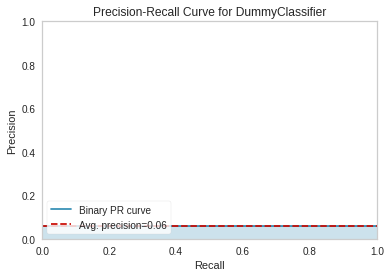

roc auc score: 0.5



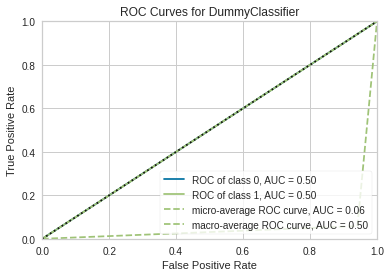

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2090
           1       0.06      1.00      0.11       133

    accuracy                           0.06      2223
   macro avg       0.03      0.50      0.06      2223
weighted avg       0.00      0.06      0.01      2223


End of validation Result



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [291]:
clf_score(dummy_clf, X_train, y_train, X_val, y_val, train=False)

## **XGBoost Classifier**

In [292]:
# Create a XBGClassifier and train the model

clf_xgb = xgb.XGBClassifier(eta=0.01, max_depth = 4, min_child_weight=1, n_estimators= 50, random_state=0)
clf_xgb.fit(X_train, y_train)

XGBClassifier(eta=0.01, max_depth=4, n_estimators=50)

Validation Result:

accuracy score: 0.6244



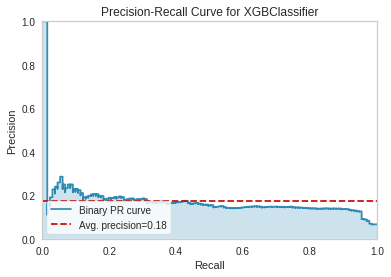

roc auc score: 0.7650375939849624



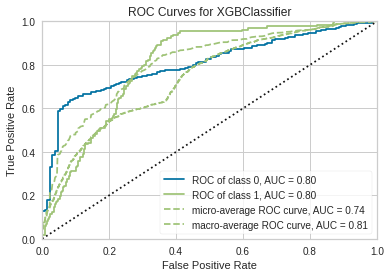

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.61      0.75      2090
           1       0.13      0.92      0.23       133

    accuracy                           0.62      2223
   macro avg       0.56      0.77      0.49      2223
weighted avg       0.94      0.62      0.72      2223


End of validation Result



In [293]:
# Performance metrics of the model

clf_score(clf_xgb, X_train, y_train, X_val, y_val, train=False)

In [294]:
# ! pip install yellowbrick 

from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC
)

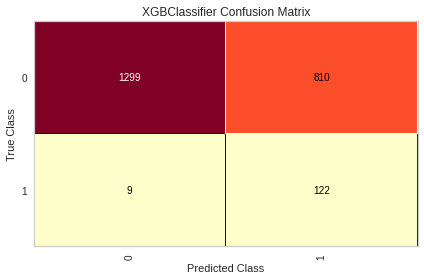

In [295]:
from yellowbrick.classifier import confusion_matrix

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(clf_xgb, classes=[0,1], is_fitted=True)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

### **PR Curve** (Enlarged)

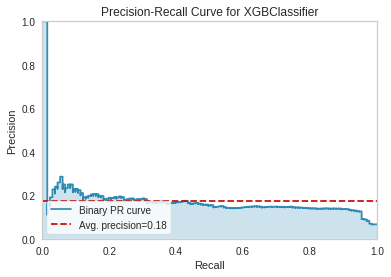

In [296]:
from yellowbrick.classifier import PrecisionRecallCurve
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(clf_xgb, is_fitted=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

### **ROC-AUC curve** (Enlarged)

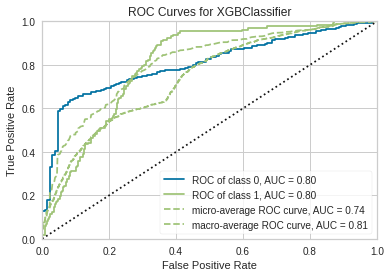

In [297]:
classes = ["0", "1"]

visualizer = ROCAUC(
    clf_xgb, classes=classes, is_fitted=True
)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  

### **Class prediction error**

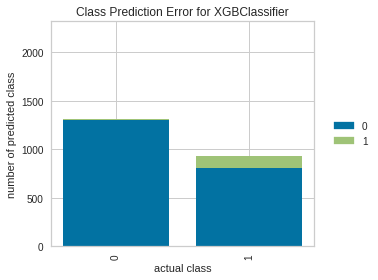

In [298]:
from yellowbrick.classifier import ClassPredictionError

classes = ["0", "1"]

visualizer = ClassPredictionError(
    clf_xgb, classes=classes, is_fitted=True
)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

### **Classification Report**

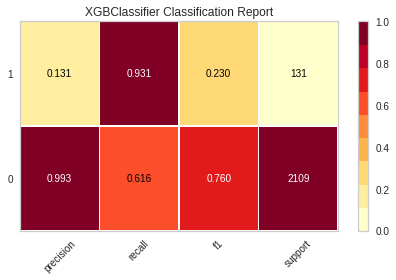

In [299]:
from yellowbrick.classifier import ClassificationReport
classes = ['0', '1']

visualizer = ClassificationReport(
    clf_xgb, classes=classes, support=True, is_fitted=True
)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize a

### **Hyperparameter Tuning**

In [300]:
##############################################
# Optimal hyperparameters
############################################

# we automatically tune (find optimal values) both hyperparameters at the same time by using Grid Search
from sklearn.model_selection import GridSearchCV

hyperparameter_space = {'n_estimators':[50, 100, 200], 
                        'eta':[ 0.01, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.5],
                        'max_depth': [4,5,6],
                        'min_child_weight': [1,2],
                        }



gs = GridSearchCV(xgb.XGBClassifier(
                                     random_state=0),
                  param_grid=hyperparameter_space, 
                   n_jobs=-1, cv=5)

gs.fit(X_train, y_train)
print("Optimal hyperparameter combination:", gs.best_params_)

KeyboardInterrupt: ignored

## **Adaboost**

In [301]:
from sklearn.ensemble import AdaBoostClassifier

In [302]:
clf_ada_boost = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_ada_boost.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=0)

Validation Result:

accuracy score: 0.1345



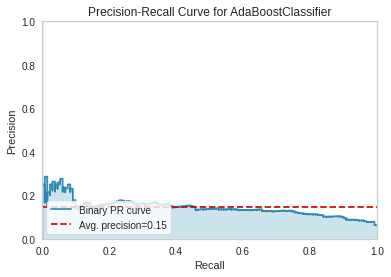

roc auc score: 0.5361927546138072



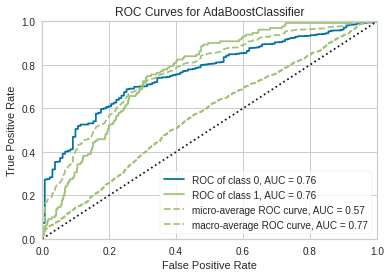

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.08      0.15      2090
           1       0.06      0.99      0.12       133

    accuracy                           0.13      2223
   macro avg       0.53      0.54      0.13      2223
weighted avg       0.94      0.13      0.15      2223


End of validation Result



In [303]:
clf_score(clf_ada_boost, X_train, y_train, X_val, y_val, train=False)

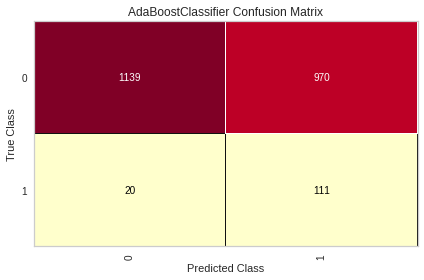

In [304]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(clf_ada_boost, classes=[0,1], is_fitted=True)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

### **PR Curve** (Enlarged)

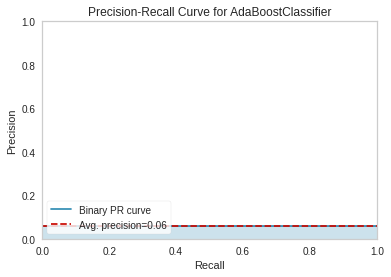

In [256]:
from yellowbrick.classifier import PrecisionRecallCurve
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(clf_ada_boost, is_fitted=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

### **ROC-AUC curve** (Enlarged)

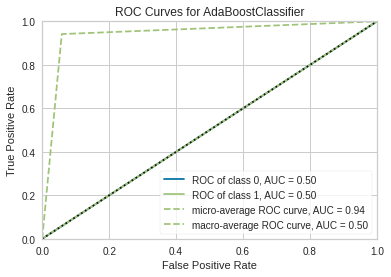

In [257]:
classes = ["0", "1"]

visualizer = ROCAUC(
    clf_ada_boost, classes=classes, is_fitted=True
)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  

### **Class prediction error**

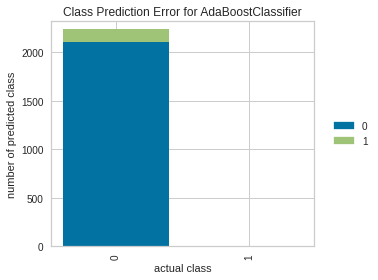

In [258]:
from yellowbrick.classifier import ClassPredictionError

classes = ["0", "1"]

visualizer = ClassPredictionError(
    clf_ada_boost, classes=classes, is_fitted=True
)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

### **Classification Report**

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


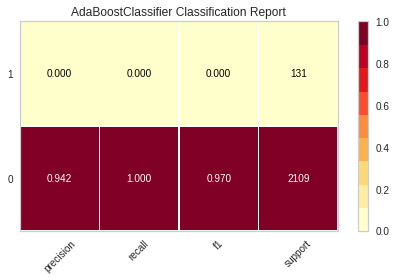

In [259]:
from yellowbrick.classifier import ClassificationReport
classes = ['0', '1']

visualizer = ClassificationReport(
    clf_ada_boost, classes=classes, support=True, is_fitted=True
)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize a